# TextCNN

Setting up the environemnt  
Install the required dependency with:
```bash
pip install numpy torch matplotlib jieba scikit-learn tqdm zhon
```

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import jieba
import re
import random
import torch
import string
import torch.nn.functional as F
from tqdm import tqdm
from torch import nn
from torch.utils.data import DataLoader
from zhon.hanzi import punctuation
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

%matplotlib inline

## data processing

### 加载数据

In [2]:
label_encoder = LabelEncoder()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

data_folder = 'D:\\TextCNN\\data\\THUCNews'
    
# Accumulate all the data with labels
all_data = []
labels = os.listdir(data_folder)
# for label in ['彩票', '家居', '时尚', '星座']:
#     labels.remove(label)
label_encoder.fit_transform(labels)


# 确定每个类别的数据量相等
import sys
min_length = sys.maxsize
for label in labels:
    label_dir = os.path.join(data_folder, label)
    if os.path.isdir(label_dir): 
        min_length = min(min_length, len(os.listdir(label_dir)))
num_classes = len(labels)
print(f'Num of labels: {num_classes}, Min number of files in the folder: {min_length}')

for label in tqdm(labels):
    label_dir = os.path.join(data_folder, label)
    if os.path.isdir(label_dir):
        for file_name in (os.listdir(label_dir)[:min_length]):
            file_path = os.path.join(label_dir, file_name)
            with open(file_path, 'r', encoding='UTF-8') as f:
                content = f.read().strip()
                all_data.append((content, label_encoder.transform([label])[0]))

# Shuffle the data and split into train, val, and test
random.shuffle(all_data)
total_size = len(all_data)
train_size = int(0.8 * total_size)
# val_size = int(0.2 * total_size)
train_data = all_data[:train_size]
# val_data = all_data[train_size:train_size+val_size]
# test_data = all_data[train_size+val_size:]
test_data = all_data[train_size:]


PAD_TOKEN = '<PAD>'
UNK_TOKEN = '<UNK>'

Num of labels: 14, Min number of files in the folder: 3578


100%|██████████| 14/14 [03:30<00:00, 15.00s/it]


### 数据处理

In [3]:
with open('D:\TextCNN\data\cn_stopwords.txt','r',encoding="utf-8") as f:
    stopwords = f.read().splitlines()
    # print(stopwords)
stopwords_set = set(stopwords)
pattern = re.compile('[0-9]|[^\\s1234567890:：\u4e00-\u9fa5]+|[%s]+' % re.escape(punctuation + string.punctuation))

def clean_and_tokenize_text(text):
    text = pattern.sub('', text)  # Combine regex substitutions
    text = ''.join(text.split())  # 去除空白
    seg_list = jieba.lcut(text)  # Segmentation
    # with open('D:\TextCNN\data\cn_stopwords.txt','r',encoding="utf-8") as f:
    #     stopwords = f.read().splitlines()
    seg_list = [word for word in seg_list if word not in stopwords_set]  # Remove stopwords
    return seg_list

def build_vocab(texts, tokenizer, max_size, min_freq):
    vocab_dic = {}
    for line in tqdm(texts):
        lin = line.strip()
        if not lin:
            continue
        content = lin.split('\t')[0]
        for word in tokenizer(content):
            vocab_dic[word] = vocab_dic.get(word, 0) + 1
    vocab_list = sorted([_ for _ in vocab_dic.items() if _[1] >= min_freq], key=lambda x: x[1], reverse=True)[:max_size]
    vocab_dic = {word_count[0]: idx for idx, word_count in enumerate(vocab_list)}
    vocab_dic.update({UNK_TOKEN: len(vocab_dic), PAD_TOKEN: len(vocab_dic) + 1})
    return vocab_dic

def random_text_mask(words, mask_prob=0.1, token=PAD_TOKEN):
    # Randomly mask words with a certain probability
    return [word if random.random() > mask_prob else token for word in words]

def random_text_delete(words, delete_prob=0.1, min_length = 20):
    # Randomly delete words with a certain probability
    if len(words) < min_length:
        return words
    return [word for word in words if random.random() > delete_prob]

def random_text_insert(words, insert_prob=0.1, insert_words=[PAD_TOKEN]):
    # Randomly insert words with a certain probability
    return [word if random.random() > insert_prob else random.choice(insert_words) for word in words]

def augment_text(words):
    # Randomly apply text augmentation techniques
    words = random_text_mask(words)
    words = random_text_delete(words)
    # words = random_text_insert(words)
    return words

In [4]:
# 数据预处理
vocab = build_vocab([item[0] for item in all_data], clean_and_tokenize_text, 20000, 10)

# Data augmentation
# print('数据增强')
# df_train['cut_words'] = df_train['cut_words'].apply(augment_text)
# print(df_train['cut_words'])

  0%|          | 0/50092 [00:00<?, ?it/s]Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\ADMINI~1\AppData\Local\Temp\jieba.cache
Loading model cost 0.670 seconds.
Prefix dict has been built successfully.
100%|██████████| 50092/50092 [02:34<00:00, 323.59it/s]


### 词向量

In [5]:
# 加载词向量
from gensim.models import KeyedVectors

path_word_vector = 'D:\TextCNN\data\\tencent-ailab-embedding-zh-d200-v0.2.0-s\\tencent-ailab-embedding-zh-d200-v0.2.0-s.txt'
path_word_vector_pickeled = 'D:\TextCNN/data/word_vector.pkl'

if os.path.exists(path_word_vector_pickeled):
        print(f"Data already exists. Loading data from {path_word_vector_pickeled}")
        with open(path_word_vector_pickeled, 'rb') as f:
            tencent_word_vector = pickle.load(f)
else: 
    tencent_word_vector = KeyedVectors.load_word2vec_format(path_word_vector, binary=False)
    with open('../data/word_vector.pkl', 'wb') as f:
        pickle.dump(tencent_word_vector, f)

print(tencent_word_vector)

Data already exists. Loading data from D:\TextCNN/data/word_vector.pkl
KeyedVectors<vector_size=200, 2000000 keys>


In [6]:
embedding_dim = tencent_word_vector.vector_size
vocab_size = len(vocab)
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, index in vocab.items():
    if word in tencent_word_vector:
        embedding_matrix[index] = tencent_word_vector[word]
    else:
        # For unknown words or padding, use random or zero values
        if word == UNK_TOKEN:
            embedding_matrix[index] = np.random.normal(scale=0.6, size=(embedding_dim, ))
        elif word == PAD_TOKEN:
            embedding_matrix[index] = np.zeros(embedding_dim)

# 5. Translate words in your text to indices
def words_to_indices(word_list):
    return [vocab[word] if word in vocab else vocab[UNK_TOKEN] for word in word_list]


In [7]:
# from torch.nn.functional import pad

PAD_LENGTH = 50

def process_data(data, tokenizer, vocab):
    contents = []
    for (content, label) in tqdm(data):
        words_line = []
        tokens = tokenizer(content)
        # tokens = augment_text(tokens)
        for word in tokens:
            words_line.append(vocab.get(word, vocab.get(UNK_TOKEN)))

        # # Pad or truncate the sequence here
        # if len(words_line) < PAD_LENGTH:
        #     # If the sequence is shorter than the target length, pad it
        #     num_padding = PAD_LENGTH - len(words_line)
        #     words_line.extend([vocab[PAD_TOKEN]] * num_padding)
        # else:
        #     # If the sequence is longer than the target length, truncate it
        #     words_line = words_line[:PAD_LENGTH]

        contents.append((words_line, label))
    return contents

train_dataset = process_data(train_data, clean_and_tokenize_text, vocab)
test_dataset = process_data(test_data, clean_and_tokenize_text, vocab)



100%|██████████| 10019/10019 [00:32<00:00, 306.23it/s]


In [8]:
from torch.nn.utils.rnn import pad_sequence

# def collate_fn(batch):
#     sequences = [item[0] for item in batch]
#     labels = [item[1] for item in batch]

#     # Convert the sequences and labels to tensors
#     sequences_tensor = torch.tensor(sequences)
#     labels_tensor = torch.tensor(labels)
    
#     return sequences_tensor, labels_tensor

def collate_fn(batch):
    return pad_sequence([torch.tensor(item[0]) for item in batch], batch_first=True, padding_value=vocab.get(PAD_TOKEN)), torch.tensor([item[1] for item in batch])


# Create a DataLoader
batch_size = 32  # Set your batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

# sample_batch = next(iter(train_loader))
# print(sample_batch)

## TextCNN Model

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TextCNN2d(nn.Module):
    def __init__(self, num_classes, num_embeddings=-1, embedding_dim=200, 
                 kernel_heights=[2, 3, 4], num_channels=[128, 128, 128], 
                 embeddings_pretrained=None, fine_tune_embeddings=False, dropout_rate=0.2):
        super(TextCNN2d, self).__init__()
        self.num_classes = num_classes
        self.num_embeddings = num_embeddings

        # embedding layer
        if self.num_embeddings > 0:
            if embeddings_pretrained is not None:
                self.embedding = nn.Embedding.from_pretrained(embeddings_pretrained, freeze=not fine_tune_embeddings)
            else:
                self.embedding = nn.Embedding(num_embeddings, embedding_dim)

        # convolutional layers
        self.cnn_layers = nn.ModuleList()
        self.convs = nn.ModuleList(
            [nn.Conv2d(1, nc, (kh, embedding_dim)) for nc, kh in zip(num_channels, kernel_heights)])        
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(sum(num_channels), num_classes)

    def conv_and_pool(self, x, conv):
        x = F.relu(conv(x)).squeeze(3)
        x = F.max_pool1d(x, x.size(2)).squeeze(2)
        return x

    def forward(self, x):
        out = self.embedding(x)
        out = out.unsqueeze(1)
        out = torch.cat([self.conv_and_pool(out, conv) for conv in self.convs], 1)
        out = self.dropout(out)
        out = self.fc(out)
        return out


In [10]:
class TextCNN1d(nn.Module):
    def __init__(self, num_classes, num_embeddings=-1, embedding_dim=200, 
                 kernel_heights=[2, 3, 4], num_channels=[128, 128, 128], 
                 embeddings_pretrained=None, fine_tune_embeddings=False, dropout_rate=0.2):
        super(TextCNN1d, self).__init__()
        self.num_classes = num_classes
        self.num_embeddings = num_embeddings

        # embedding layer
        if self.num_embeddings > 0:
            if embeddings_pretrained is not None:
                self.embedding = nn.Embedding.from_pretrained(embeddings_pretrained, freeze=not fine_tune_embeddings)
            else:
                self.embedding = nn.Embedding(num_embeddings, embedding_dim)

        # convolutional layers
        # Notice the change here in Conv1d
        self.convs = nn.ModuleList(
            [nn.Conv1d(embedding_dim, nc, kh) for nc, kh in zip(num_channels, kernel_heights)])
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(sum(num_channels), num_classes)

    def conv_and_pool(self, x, conv):
        x = F.relu(conv(x))
        # We use max_pool1d and change dimensions
        x = F.max_pool1d(x, x.size(2)).squeeze(2)
        return x

    def forward(self, x):
        out = self.embedding(x)
        out = out.permute(0,2,1)
        # No need to unsqueeze
        out = torch.cat([self.conv_and_pool(out, conv) for conv in self.convs], 1)
        out = self.dropout(out)
        out = self.fc(out)
        return out


## Train

In [11]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        CE_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-CE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * CE_loss

        if self.reduction == 'sum':
            return F_loss.sum()
        elif self.reduction == 'mean':
            return F_loss.mean()
        else:
            return F_loss

In [57]:
from sklearn import metrics
from datetime import timedelta


def get_time_dif(start_time):
    """获取已使用时间"""
    end_time = time.time()
    time_dif = end_time - start_time
    return timedelta(seconds=int(round(time_dif)))

def evaluate(model, dataloader: DataLoader, test=False):
    model.eval()
    loss_total = 0
    predict_all = np.array([], dtype=int)
    labels_all = np.array([], dtype=int)
    with torch.no_grad():
        for texts, labels in dataloader:
            texts, labels = texts.to(device).long(), labels.to(device).long()
            outputs = model(texts)
            loss = F.cross_entropy(outputs, labels)
            loss_total += loss
            labels = labels.data.cpu().numpy()
            predic = torch.max(outputs.data, 1)[1].cpu().numpy()
            labels_all = np.append(labels_all, labels)
            predict_all = np.append(predict_all, predic)

    acc = metrics.accuracy_score(labels_all, predict_all)
    if test:
        report = metrics.classification_report(labels_all, predict_all, target_names=label_encoder.classes_, digits=4)
        confusion = metrics.confusion_matrix(labels_all, predict_all)
        return acc, loss_total / len(dataloader), report, confusion
    return acc, loss_total / len(dataloader)


def test(model, test_loader, verbose= True):
    # model.load_state_dict(torch.load(config.save_path))
    model.eval()
    start_time = time.time()
    test_acc, test_loss, test_report, test_confusion = evaluate(model, test_loader, test=True)
    if verbose:
        msg = 'Test Loss: {0:>5.2},  Test Acc: {1:>6.2%}'
        print(msg.format(test_loss, test_acc))
        print("Precision, Recall and F1-Score...")
        print(test_report)
        print("Confusion Matrix...")
        print(test_confusion)
        time_dif = get_time_dif(start_time)
        print("Time usage:", time_dif)
    return test_acc

### Train Conv1d

In [114]:
# Initialize the model
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# device = torch.device('cpu')
batch_size = 32
num_classes = 14  # 输出类别
context_size = PAD_LENGTH  # 句子长度（字词个数） 
num_embeddings = vocab_size  # 词典的大小(vocab_size)
embedding_dim = embedding_dim  # 词向量特征长度
kernel_heights = [2, 3, 4, 5]  # CNN层卷积核大小
num_channels = [256, 256, 256, 256]  # CNN层卷积核通道数
input = torch.ones(size=(batch_size, context_size)).long().to(device)
model = TextCNN1d(num_classes=num_classes,
                num_embeddings=num_embeddings,
                embedding_dim=embedding_dim,
                kernel_heights=kernel_heights,
                num_channels=num_channels,
                fine_tune_embeddings=False,
                embeddings_pretrained=torch.tensor(embedding_matrix).float(),
                dropout_rate=0.5
                )
model = model.to(device)
print(model)
model.eval()
output = model(input)
print("-----" * 10)
print("-----" * 10)
print("input.shape:{}".format(input.shape))
print("output.shape:{}".format(output.shape))

TextCNN1d(
  (embedding): Embedding(20002, 200)
  (convs): ModuleList(
    (0): Conv1d(200, 256, kernel_size=(2,), stride=(1,))
    (1): Conv1d(200, 256, kernel_size=(3,), stride=(1,))
    (2): Conv1d(200, 256, kernel_size=(4,), stride=(1,))
    (3): Conv1d(200, 256, kernel_size=(5,), stride=(1,))
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=1024, out_features=14, bias=True)
)
--------------------------------------------------
--------------------------------------------------
input.shape:torch.Size([32, 50])
output.shape:torch.Size([32, 14])


In [66]:
# Train the model

from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Assume num_epochs is the number of epochs you want to train your model for
num_epochs = 20

# KFold
num_folds = 5
kf = KFold(n_splits=num_folds)

# Initialize the optimizer
optimizer = Adam(model.parameters(), weight_decay=0.001, lr=2.5e-04)

scheduler = ReduceLROnPlateau(optimizer, 'min', verbose=True)  # Reduce learning rate when a metric has stopped improving

# Gradient clipping
clip = 5

# Initialize the loss function
padding_index = vocab[PAD_TOKEN]
criterion = nn.CrossEntropyLoss().to(device)
# criterion = FocalLoss(alpha=0.25, gamma=2).to(device)


# Define early stopping parameters
early_stopping_patience = 800  # How many batches with no improvement before we stop training
start_time = time.time()

for fold, (train_index, val_index) in enumerate(kf.split(train_dataset)):
    print(f'Fold {fold+1}')

    train_data_fold = [train_dataset[i] for i in train_index]
    val_data_fold = [train_dataset[i] for i in val_index]

    train_dataloader = DataLoader(train_data_fold, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_data_fold, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    # Initialize variables for early stopping
    val_best_loss = float('inf')
    no_improvement_count = 0
    num_batch = 0
    flag = False

    # Training and validation loops
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        
        # for batch in train_loader:
        for batch, (inputs, labels) in enumerate(train_dataloader):
            # inputs, labels = batch
            inputs, labels = inputs.to(device).long(), labels.to(device).long()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if batch % 200 == 0:
                # 每多少轮输出在训练集和验证集上的效果
                true = labels.data.cpu()
                predic = torch.max(outputs.data, 1)[1].cpu()
                train_acc = metrics.accuracy_score(true, predic)
                val_acc, val_loss = evaluate(model, val_loader)
                if val_loss < val_best_loss:
                    val_best_loss = val_loss
                    # torch.save(model.state_dict(), config.save_path)
                    last_improve = batch
                print(f'Total batch {batch+num_batch}, Train Loss: {loss.item()}, Train Acc: {train_acc*100}%, Val Loss: {val_loss}, Val Acc: {val_acc*100}%')

            if batch - last_improve > early_stopping_patience:
                print(f"No optimization for {early_stopping_patience} batches, auto-stopping...")
                flag = True
                break
        if flag:
            break

        num_batch += train_dataloader.__len__()

        # Step the learning rate scheduler
        scheduler.step(val_loss)

        # If needed, load the best mode l from this fold
        # model.load_state_dict(torch.load(f'model_fold_{fold+1}_best.pth'))
    
print(f'Time used for training: {get_time_dif(start_time)}\n')
test(model, test_loader)

Fold 1
Total batch 0, Train Loss: 2.6565334796905518, Train Acc: 6.25%, Val Loss: 2.6470932960510254, Val Acc: 8.533998752339365%
Total batch 200, Train Loss: 0.7005876898765564, Train Acc: 93.75%, Val Loss: 0.6982632279396057, Val Acc: 86.27573300062383%
Total batch 400, Train Loss: 0.45729759335517883, Train Acc: 84.375%, Val Loss: 0.38999634981155396, Val Acc: 89.50717404865877%
Total batch 600, Train Loss: 0.252711683511734, Train Acc: 96.875%, Val Loss: 0.30831965804100037, Val Acc: 91.66562694946975%
Total batch 800, Train Loss: 0.11716160178184509, Train Acc: 96.875%, Val Loss: 0.25918495655059814, Val Acc: 93.25015595757954%
Total batch 1000, Train Loss: 0.09003600478172302, Train Acc: 100.0%, Val Loss: 0.23438486456871033, Val Acc: 93.67436057392389%
Total batch 1002, Train Loss: 0.09334787726402283, Train Acc: 100.0%, Val Loss: 0.2356608659029007, Val Acc: 93.63693075483468%
Total batch 1202, Train Loss: 0.2203342616558075, Train Acc: 93.75%, Val Loss: 0.21567155420780182, Va

0.9595768040722626

In [ ]:
# # 模型训练可视化

# from torch.optim import Adam
# from torch.optim.lr_scheduler import ReduceLROnPlateau

# # Assume num_epochs is the number of epochs you want to train your model for
# num_epochs = 1


# # Initialize the optimizer
# optimizer = Adam(model.parameters(), weight_decay=0.001, lr=2.5e-04)

# scheduler = ReduceLROnPlateau(optimizer, 'min', verbose=True)  # Reduce learning rate when a metric has stopped improving

# # Gradient clipping
# clip = 5

# # Initialize the loss function
# padding_index = vocab[PAD_TOKEN]
# criterion = nn.CrossEntropyLoss().to(device)
# # criterion = FocalLoss(alpha=0.25, gamma=2).to(device)


# # Define early stopping parameters
# early_stopping_patience = 500  # How many batches with no improvement before we stop training
# start_time = time.time()

# batches_tracked = []
# test_accuracies = []
# epoch_points = []

# # Initialize variables for early stopping
# val_best_loss = float('inf')
# no_improvement_count = 0
# num_batch = 0

# # Training and validation loops
# for epoch in range(num_epochs):
#     model.train()  # Set the model to training mode
    
#     # for batch in train_loader:
#     for batch, (inputs, labels) in enumerate(train_loader):
#         # inputs, labels = batch
#         inputs, labels = inputs.to(device).long(), labels.to(device).long()

#         # Forward pass
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)

#         # Backward pass and optimization
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         if batch % 10 == 0:
#             # 每多少轮输出在训练集和验证集上的效果
#             # true = labels.data.cpu()
#             # predic = torch.max(outputs.data, 1)[1].cpu()
#             # train_acc = metrics.accuracy_score(true, predic)
#             # val_acc, val_loss = evaluate(model, val_loader)
#             # if val_loss < val_best_loss:
#             #     val_best_loss = val_loss
#             #     # torch.save(model.state_dict(), config.save_path)
#             #     last_improve = batch
#             # print(f'Total batch {batch+num_batch}, Train Loss: {loss.item()}, Train Acc: {train_acc*100}%, Val Loss: {val_loss}, Val Acc: {val_acc*100}%')
#             test_acc = test(model, test_loader, False)  # Assuming your test function returns accuracy
#             batches_tracked.append(batch + num_batch)
#             test_accuracies.append(test_acc)

#         # if batch - last_improve > early_stopping_patience:
#         #     print(f"No optimization for {early_stopping_patience} batches, auto-stopping...")
#         #     flag = True
#         #     break
#     # if flag:
#         # break

#     epoch_points.append(num_batch)
#     num_batch += train_dataloader.__len__()

#     # Step the learning rate scheduler
#     scheduler.step(val_loss)

#     # If needed, load the best mode l from this fold
#     # model.load_state_dict(torch.load(f'model_fold_{fold+1}_best.pth'))
    
# print(f'Time used for training: {get_time_dif(start_time)}\n')
# test(model, test_loader)
# plt.plot(batches_tracked, test_accuracies)
# plt.scatter(epoch_points, [test_accuracies[batches_tracked.index(point)] for point in epoch_points], color='red', label='Epochs')
# for i, point in enumerate(epoch_points):
#     plt.annotate(f'Epoch {i+1}', (point, test_accuracies[batches_tracked.index(point)]), textcoords="offset points", xytext=(-10,-10), ha='center')
# plt.xlabel("Number of Batches")
# plt.ylabel("Test Accuracy")
# plt.title("Data Increment vs Test Accuracy")
# plt.grid(True)
# plt.legend()
# plt.show()

## 增量测试

In [141]:
# Initialize the model
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# device = torch.device('cpu')
batch_size = 32
num_classes = 14  # 输出类别
context_size = PAD_LENGTH  # 句子长度（字词个数） 
num_embeddings = vocab_size  # 词典的大小(vocab_size)
embedding_dim = embedding_dim  # 词向量特征长度
kernel_heights = [2, 3, 4, 5]  # CNN层卷积核大小
num_channels = [256, 256, 256, 256]  # CNN层卷积核通道数
input = torch.ones(size=(batch_size, context_size)).long().to(device)
model = TextCNN1d(num_classes=num_classes,
                num_embeddings=num_embeddings,
                embedding_dim=embedding_dim,
                kernel_heights=kernel_heights,
                num_channels=num_channels,
                fine_tune_embeddings=False,
                embeddings_pretrained=torch.tensor(embedding_matrix).float(),
                dropout_rate=0.5
                )
model = model.to(device)
print(model)
model.eval()
output = model(input)
print("-----" * 10)
print("-----" * 10)
print("input.shape:{}".format(input.shape))
print("output.shape:{}".format(output.shape))

TextCNN1d(
  (embedding): Embedding(20002, 200)
  (convs): ModuleList(
    (0): Conv1d(200, 256, kernel_size=(2,), stride=(1,))
    (1): Conv1d(200, 256, kernel_size=(3,), stride=(1,))
    (2): Conv1d(200, 256, kernel_size=(4,), stride=(1,))
    (3): Conv1d(200, 256, kernel_size=(5,), stride=(1,))
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=1024, out_features=14, bias=True)
)
--------------------------------------------------
--------------------------------------------------
input.shape:torch.Size([32, 50])
output.shape:torch.Size([32, 14])


c:\Users\Administrator\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Administrator\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Administrator\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

Time used for training: 0:27:30

Test Loss:  0.15,  Test Acc: 95.78%
Precision, Recall and F1-Score...
              precision    recall  f1-score   support

          体育     0.9958    0.9903    0.9931       722
          娱乐     0.9844    0.9858    0.9851       703
          家居     0.9521    0.9858    0.9686       705
          彩票     0.9846    0.9860    0.9853       715
          房产     0.9957    0.9777    0.9866       716
          教育     0.9461    0.9372    0.9416       749
          时尚     0.9845    0.9562    0.9702       731
          时政     0.9379    0.9551    0.9464       712
          星座     0.9944    0.9847    0.9895       718
          游戏     0.9930    0.9820    0.9875       723
          社会     0.8618    0.9434    0.9007       707
          科技     0.9530    0.9298    0.9413       698
          股票     0.9011    0.9487    0.9243       682
          财经     0.9330    0.8496    0.8894       738

    accuracy                         0.9578     10019
   macro avg     0.9584    0.95

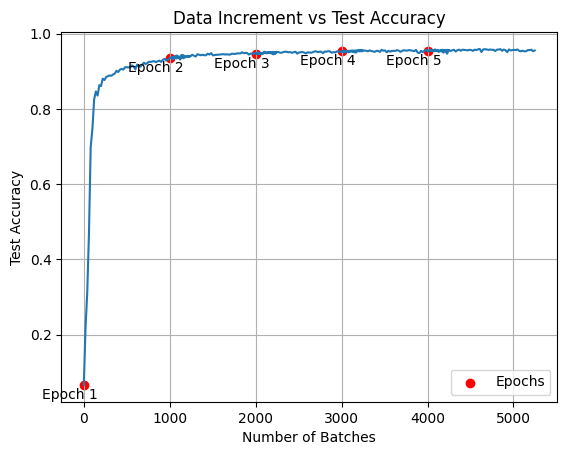

In [142]:
# Train the model

from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Assume num_epochs is the number of epochs you want to train your model for
num_epochs = 5

# Initialize the optimizer
optimizer = Adam(model.parameters(), weight_decay=0.001, lr=2.5e-04)

scheduler = ReduceLROnPlateau(optimizer, 'min', verbose=True)  # Reduce learning rate when a metric has stopped improving

# Gradient clipping
clip = 5

# Initialize the loss function
padding_index = vocab[PAD_TOKEN]
criterion = nn.CrossEntropyLoss().to(device)
# criterion = FocalLoss(alpha=0.25, gamma=2).to(device)


# Define early stopping parameters
early_stopping_patience = 500  # How many batches with no improvement before we stop training
start_time = time.time()

batches_tracked = []
test_accuracies_full = []
epoch_points = []

# Initialize variables for early stopping
val_best_loss = float('inf')
no_improvement_count = 0
num_batch = 0

# Training and validation loops
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    
    # for batch in train_loader:
    for batch, (inputs, labels) in enumerate(train_loader):
        # inputs, labels = batch
        inputs, labels = inputs.to(device).long(), labels.to(device).long()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 20 == 0:            # 每多少轮输出在训练集和验证集上的效果
            # true = labels.data.cpu()
            # predic = torch.max(outputs.data, 1)[1].cpu()
            # train_acc = metrics.accuracy_score(true, predic)
            # val_acc, val_loss = evaluate(model, val_loader)
            # if val_loss < val_best_loss:
            #     val_best_loss = val_loss
            #     # torch.save(model.state_dict(), config.save_path)
            #     last_improve = batch
            # print(f'Total batch {batch+num_batch}, Train Loss: {loss.item()}, Train Acc: {train_acc*100}%, Val Loss: {val_loss}, Val Acc: {val_acc*100}%')
            test_acc = test(model, test_loader, False)  # Assuming your test function returns accuracy
            batches_tracked.append(num_batch+batch)
            test_accuracies_full.append(test_acc)

        # if batch - last_improve > early_stopping_patience:
        #     print(f"No optimization for {early_stopping_patience} batches, auto-stopping...")
        #     flag = True
        #     break
    # if flag:
        # break

    epoch_points.append(num_batch)
    num_batch += train_dataloader.__len__()

    # Step the learning rate scheduler
    scheduler.step(val_loss)

    # If needed, load the best mode l from this fold
    # model.load_state_dict(torch.load(f'model_fold_{fold+1}_best.pth'))
    
print(f'Time used for training: {get_time_dif(start_time)}\n')
test(model, test_loader)
plt.plot(batches_tracked, test_accuracies_full)
plt.scatter(epoch_points, [test_accuracies_full[batches_tracked.index(point)] for point in epoch_points], color='red', label='Epochs')
for i, point in enumerate(epoch_points):
    plt.annotate(f'Epoch {i+1}', (point, test_accuracies_full[batches_tracked.index(point)]), textcoords="offset points", xytext=(-10,-10), ha='center')
plt.xlabel("Number of Batches")
plt.ylabel("Test Accuracy")
plt.title("Data Increment vs Test Accuracy")
plt.grid(True)
plt.legend()
plt.show()


c:\Users\Administrator\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Administrator\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Administrator\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

Time used for training: 0:31:02

Test Loss:  0.15,  Test Acc: 95.57%
Precision, Recall and F1-Score...
              precision    recall  f1-score   support

          体育     0.9958    0.9931    0.9945       722
          娱乐     0.9762    0.9915    0.9838       703
          家居     0.9784    0.9645    0.9714       705
          彩票     0.9847    0.9874    0.9860       715
          房产     0.9648    0.9944    0.9794       716
          教育     0.9454    0.9239    0.9345       749
          时尚     0.9663    0.9795    0.9728       731
          时政     0.9465    0.9438    0.9451       712
          星座     0.9944    0.9847    0.9895       718
          游戏     0.9584    0.9889    0.9735       723
          社会     0.8740    0.9321    0.9021       707
          科技     0.9584    0.9241    0.9409       698
          股票     0.9133    0.9267    0.9199       682
          财经     0.9246    0.8469    0.8840       738

    accuracy                         0.9557     10019
   macro avg     0.9558    0.95

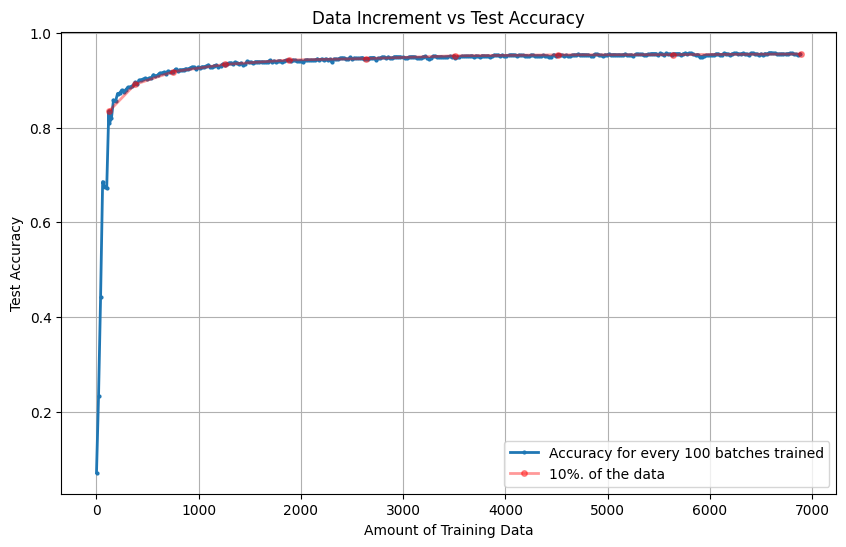

In [140]:
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau


# Initialize the optimizer
optimizer = Adam(model.parameters(), weight_decay=0.001, lr=2.5e-04)

scheduler = ReduceLROnPlateau(optimizer, 'min', verbose=True)  # Reduce learning rate when a metric has stopped improving

# Gradient clipping
clip = 5

# Initialize the loss function
padding_index = vocab[PAD_TOKEN]
criterion = nn.CrossEntropyLoss().to(device)
# criterion = FocalLoss(alpha=0.25, gamma=2).to(device)


# Define early stopping parameters
early_stopping_patience = 500  # How many batches with no improvement before we stop training
start_time = time.time()

test_accuracies = []
epoch_points = []

# Initialize variables for early stopping
val_best_loss = float('inf')
no_improvement_count = 0
num_batch = 0


# Convert train_dataset to list and split into 5 chunks
train_data_list = list(train_loader.dataset)
split_size = len(train_data_list) // 10

data_chunks = [train_data_list[i:i + split_size] for i in range(0, len(train_data_list), split_size)]

# Make sure we only have 5 chunks
data_chunks = data_chunks[:10]

# List to track total data size and accuracies
data_sizes = []
data_size_segments = []
test_accuracies_segments = []
test_accuracies = []

num_epochs_per_chunk = 1

accumulated_data = []
points = 0
for chunk_idx, data_chunk in enumerate(data_chunks):
    accumulated_data.extend(data_chunk)
    
    # Create DataLoader for the accumulated data
    accumulated_loader = DataLoader(accumulated_data, batch_size=train_loader.batch_size, shuffle=True, collate_fn= collate_fn)
    
    # Train on this accumulated data for num_epochs_per_chunk epochs
    for epoch in range(num_epochs_per_chunk):
        model.train()
        
        for batch, (inputs, labels) in enumerate(accumulated_loader):
            points +=1
            model.train()
            inputs, labels = inputs.to(device).long(), labels.to(device).long()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if batch % 20 == 0:
                test_acc = test(model, test_loader, False)
                data_sizes.append(points)
                test_accuracies.append(test_acc)

        # Step the learning rate scheduler (if you want to step every epoch)
        scheduler.step(loss)
        test_accuracies_segments.append(test_acc)
        data_size_segments.append(points)

        
            
print(f'Time used for training: {get_time_dif(start_time)}\n')
test(model, test_loader)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(data_sizes, test_accuracies, '-o', linewidth=2, markersize=2, label= 'Accuracy for every 100 batches trained')
plt.plot(data_size_segments, test_accuracies_segments, '-o', linewidth=2, markersize=4, color='red', alpha= 0.4, label= '10%. of the data')
plt.xlabel("Amount of Training Data")
plt.ylabel("Test Accuracy")
plt.title("Data Increment vs Test Accuracy")
plt.grid(True)
plt.legend()
plt.show()

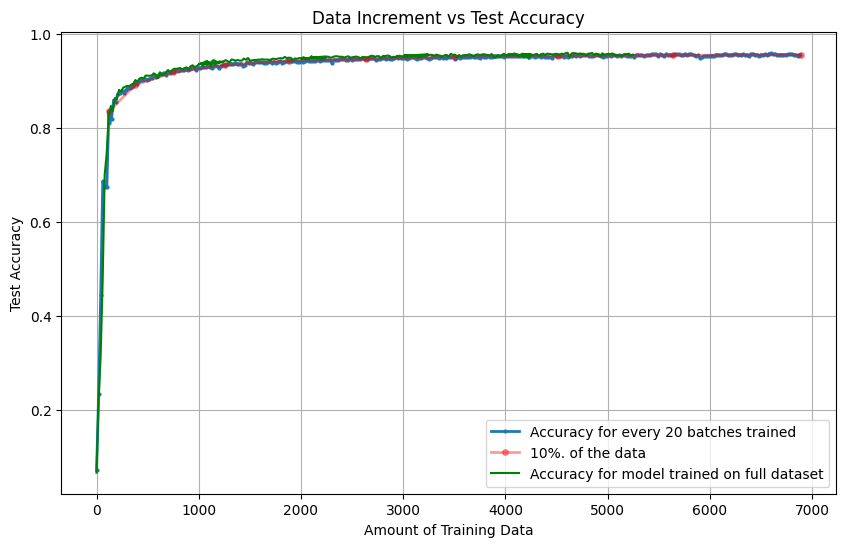

In [145]:
# Plot
plt.figure(figsize=(10, 6))
plt.plot(data_sizes, test_accuracies, '-o', linewidth=2, markersize=2, label= 'Accuracy for every 20 batches trained')
plt.plot(data_size_segments, test_accuracies_segments, '-o', linewidth=2, markersize=4, color='red', alpha= 0.4, label= '10%. of the data')
plt.plot(batches_tracked, test_accuracies_full, label= 'Accuracy for model trained on full dataset', color = 'green')
plt.xlabel("Amount of Training Data")
plt.ylabel("Test Accuracy")
plt.title("Data Increment vs Test Accuracy")
plt.grid(True)
# plt.ylim([0.7,1.0])
# plt.xlim([0,5000])
plt.legend()
plt.show()

## 性能测试

In [15]:
device_test = 'cpu'

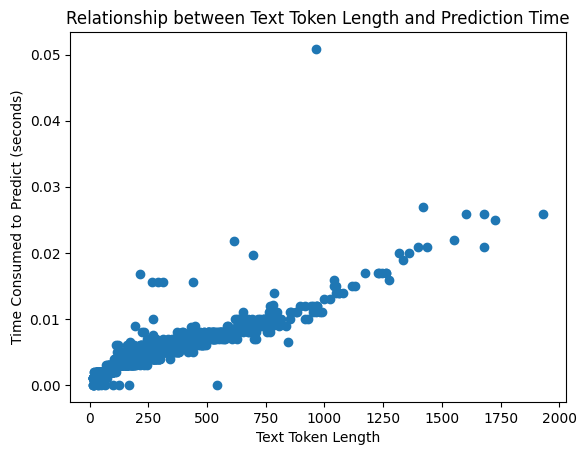

In [23]:
# Lists to store the token lengths and time consumed for each prediction
token_lengths = []
time_consumed = []

for _ in range(1000):
    index = random.randint(0,len(test_data))
    instance = test_data[index]
    text = instance[0]
    actual_label = label_encoder.inverse_transform([instance[1]])[0]
    label_encoded = instance[1]
    words = clean_and_tokenize_text(text)
    words_indice = words_to_indices(words)
    model.to(device_test)

    start_time = time.time()
    with torch.no_grad():
        model.eval()
        data, label = torch.tensor(words_indice), torch.tensor(label_encoded)
        data = data.unsqueeze(0).to(device_test)
        label = label.to(device_test)
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
    end_time = time.time()

    # Append the text token length and time consumed to predict to the lists
    token_lengths.append(len(words))
    time_consumed.append(end_time - start_time)

# Create a scatter plot to visualize the relationship
plt.scatter(token_lengths, time_consumed)
plt.xlabel('Text Token Length')
plt.ylabel('Time Consumed to Predict (seconds)')
plt.title('Relationship between Text Token Length and Prediction Time')
plt.show()

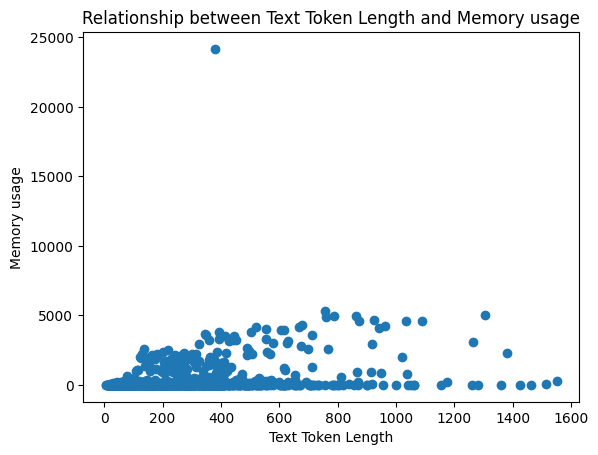

In [16]:
import os
import psutil

process = psutil.Process(os.getpid())

memory_usages = []
cpu_usages = []
text_lengths = []

for _ in range(1000):
    mem_info_before = process.memory_info()
    # cpu_percent_before = process.cpu_percent(interval=None)

    index = random.randint(0,len(test_data))
    instance = test_data[index]
    text = instance[0]
    actual_label = label_encoder.inverse_transform([instance[1]])[0]
    label_encoded = instance[1]
    words = clean_and_tokenize_text(text)
    words_indice = words_to_indices(words)
    model.to(device_test)

    start_time = time.time()
    with torch.no_grad():
        model.eval()
        data, label = torch.tensor(words_indice), torch.tensor(label_encoded)
        data = data.unsqueeze(0).to(device_test)
        label = label.to(device_test)
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
    end_time = time.time()

    mem_info_after = process.memory_info()
    cpu_percent_after = process.cpu_percent(interval=None)

    memory_usages.append((mem_info_after.rss - mem_info_before.rss)/1000)
    # cpu_usages.append(cpu_percent_after - cpu_percent_before)
    text_lengths.append(len(words))

plt.scatter(text_lengths, memory_usages)
plt.xlabel('Text Token Length')
plt.ylabel('Memory usage')
plt.title('Relationship between Text Token Length and Memory usage')
plt.show()

In [17]:
import os
import psutil

process = psutil.Process(os.getpid())

mem_info_before = process.memory_info()
cpu_percent_before = process.cpu_percent(interval=None)

index = random.randint(0,len(test_data))
instance = test_data[index]
text = instance[0]
actual_label = label_encoder.inverse_transform([instance[1]])[0]
label_encoded = instance[1]
words = clean_and_tokenize_text(text)
words_indice = words_to_indices(words)
model.to(device_test)

start_time = time.time()
with torch.no_grad():
    model.eval()
    data, label = torch.tensor(words_indice), torch.tensor(label_encoded)
    data = data.unsqueeze(0).to(device_test)
    label = label.to(device_test)
    outputs = model(data)
    _, predicted = torch.max(outputs.data, 1)
end_time = time.time()

mem_info_after = process.memory_info()
cpu_percent_after = process.cpu_percent(interval=None)

print(f"Original text: {text[:100]}")
print(f'文本长度：{len(text)}')
print(f"Text tokens: {words[:100]} \nLength of text tokens: {len(words)}")
print(f"The actual label is: {actual_label}")
print(f"The predicted label is: {label_encoder.inverse_transform([predicted.item()])[0]}")
print(f"Time spent on predicting one text: {end_time - start_time} seconds")

print(f"Memory used: {mem_info_after.rss - mem_info_before.rss} bytes")
print(f"CPU percent: {cpu_percent_after - cpu_percent_before}%")

Original text: 网上公务员考试代考费最高达万元
　　考试日益临近 代考生意火爆 自称“内部有人”
　　火爆异常的公务员报考形势不仅带火了“国考”的人气，也顺势为“枪手”和代考机构提供了“生意”。随着11月30日公务员
文本长度：1182
Text tokens: ['网上', '公务员', '考试', '代考', '费', '最高', '达', '万元', '考试', '日益', '近代', '考生', '意', '火爆', '自称', '内部', '有人', '火爆', '异常', '公务员', '报考', '形势', '带火', '国考', '人气', '顺势', '枪手', '代考', '机构', '提供', '生意', '月', '日', '公务员', '录用', '考试', '日期', '日益', '临近', '网上', '求助', '枪手', '提供', '代考', '帖子', '争相', '浮出', '水面', '记者', '发现', '国考', '代考', '费用', '标价', '不菲', '数千元', '上万元', '推出', '分批', '付款', '付', '赔偿金', '服务措施', '对此', '国家', '公务员', '考试', '主管部门', '人士', '表示', '届时', '采取', '严密', '措施', '枪手', '代考', '打击', '绝不', '手软', '记者', '暗访', '专业', '枪手', '包', '满意', '上网', '搜索', '一下', '公务员', '考试', '代考', '各类', '吆喝', '提供', '代考', '服务', '信息', '充斥', '网页', '不乏'] 
Length of text tokens: 349
The actual label is: 社会
The predicted label is: 社会
Time spent on predicting one text: 0.00797891616821289 seconds
Memory used: 0 bytes
CPU percent: 97.7%


In [18]:
# 错误分类示例
import os
import psutil

counter = 0
while True:
    counter += 1
    process = psutil.Process(os.getpid())

    mem_info_before = process.memory_info()
    cpu_percent_before = process.cpu_percent(interval=None)

    index = random.randint(0,len(test_data))
    instance = test_data[index]
    text = instance[0]
    actual_label = label_encoder.inverse_transform([instance[1]])[0]
    label_encoded = instance[1]
    words = clean_and_tokenize_text(text)
    words_indice = words_to_indices(words)
    model.to(device_test)

    start_time = time.time()
    with torch.no_grad():
        model.eval()
        data, label = torch.tensor(words_indice), torch.tensor(label_encoded)
        data = data.unsqueeze(0).to(device_test)
        label = label.to(device_test)
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
    end_time = time.time()

    mem_info_after = process.memory_info()
    cpu_percent_after = process.cpu_percent(interval=None)

    if predicted.item() != label_encoded:
        break

print(f"Number of texts traversed: {counter}")
print(f"Original text: {text[:100]}")
print(f'文本长度：{len(text)}')
print(f"Text tokens: {words[:100]} \nLength of text tokens: {len(words)}")
print(f"The actual label is: {actual_label}")
print(f"The predicted label is: {label_encoder.inverse_transform([predicted.item()])[0]}")
print(f"Time spent on predicting one text: {end_time - start_time} seconds")

print(f"Memory used: {mem_info_after.rss - mem_info_before.rss} bytes")

print(f"CPU percent: {cpu_percent_after - cpu_percent_before}%")

Number of texts traversed: 14
Original text: 外交部回应白宫报告：将继续推进汇率改革

　　美方认为，去年下半年以来人民币升值迅速，而且中国正采取措施加大汇率的灵活性
　　⊙本报记者 朱周良
　　15日，白宫发布了奥巴马上台后首份所谓“国际经济和
文本长度：1944
Text tokens: ['外交部', '回应', '白宫', '报告', '继续', '推进', '汇率', '改革', '美方', '认为', '去年', '下半年', '人民币', '升值', '迅速', '中国', '正', '采取措施', '加大', '汇率', '灵活性', '本报记者', '朱周', '良日', '白宫', '发布', '奥巴马', '上台', '首份', '所谓', '国际', '经济', '汇率', '政策', '情况', '报告', '前一天', '消息', '称', '人民币', '可能', '正式', '指控', '最终', '奥巴马', '政府', '排除', '有限', '噪声', '干扰', '称', '没有', '发现', '包括', '中国', '在内', '主要', '贸易', '伙伴', '操纵', '汇率', '获取', '公平', '贸易', '优势', '白宫', '此份', '报告', '中国外交部', '昨日', '作出', '回应', '称', '继续', '推进', '人民币', '汇率', '形成', '机制', '改革', '中国外交部', '发言人', '姜瑜', '昨日', '举行', '例行', '记者会', '表示', '目标', '合理', '均衡', '水平', '保持', '人民币', '币值', '基本', '稳定', '有利于', '中国', '有利于'] 
Length of text tokens: 627
The actual label is: 财经
The predicted label is: 股票
Time spent on predicting one text: 0.009974241256713867 seconds
Memory used: 8192 bytes
CPU percent: 390.6%


In [19]:
print(text)

外交部回应白宫报告：将继续推进汇率改革

　　美方认为，去年下半年以来人民币升值迅速，而且中国正采取措施加大汇率的灵活性
　　⊙本报记者 朱周良
　　15日，白宫发布了奥巴马上台后首份所谓“国际经济和汇率政策情况报告”。尽管此前一天有消息称人民币可能被正式“指控”，但最终奥巴马政府还是排除了有限的噪声干扰，称没有发现包括中国在内的主要贸易伙伴操纵汇率以获取不公平贸易优势。
　　对于白宫的此份报告，中国外交部昨日作出回应称：将继续推进人民币汇率形成机制的改革。中国外交部发言人姜瑜在昨日举行的例行记者会上表示，“我们的目标是在合理、均衡的水平上，保持人民币币值的基本稳定，这不仅有利于中国，也有利于世界经济。”此外，姜瑜在回答关于购买美国国债的问题时指出，中国的外汇储备经营始终是按照安全、流动、保值的原则，坚持多元化投资战略。
　　人民币对美元升值迅速
　　在15日提交给国会半年一次的报告中，美国财政部表示，美国几乎所有的贸易伙伴都受到当前全球经济衰退的打击，但财政部并未发现有任何国家或经济体操纵汇率以使本国贸易受益。
　　根据美国国会的要求，美国财政部必须每6个月向国会提交一份关于国际经济和汇率政策情况报告，对世界各国和地区的汇率政策进行评估，并判定哪些国家有“操纵汇率”行为。下次的报告预定在10月公布。
　　对于中国，美财政部的最新报告认为，去年下半年以来人民币升值迅速，中国正采取措施加大汇率的灵活性。报告注意到，从2008年6月至今年2月期间，人民币对美元累计升值了16.6%。去年下半年以来，随着国际金融危机加深，大多数新兴经济体货币对美元比价急剧下跌，而人民币对美元比价还有所上升。但报告声称，人民币仍被低估。
　　舒默称白宫选择正确
　　美国媒体注意到，奥巴马政府在人民币汇率问题上的最新表态，与他几个月前竞选总统期间的强硬立场形成鲜明对比。
　　奥巴马在竞选总统时一度被认为对中国颇有微词，他当时指责中国“操纵”人民币汇率，并暗示会通过法案对中国实施报复。而奥巴马钦点的财政部长盖特纳也在1月底公开指责中国的汇率政策。盖特纳当时在国会作证时称，奥巴马认为中国在“操纵”人民币汇率，他将敦促中国改变在汇率上的做法。
　　14日，也就是财政部报告公布前一天，路透社引述美国对外贸易委员会主席赖因施的话报道称，奥巴马政府可能在定于周三公布的报告中正式指控中国“操纵”人民币汇率。

In [20]:
print(f"{text}")
print(f'文本长度：{len(text)}')
print(f"Text tokens: {words[:50]} \nLength of text tokens: {len(words)}")
print(f"The actual label is: {actual_label}")
print(f"The predicted label is: {label_encoder.inverse_transform([predicted.item()])[0]}")
print(f"Time spent on predicting one text: {end_time - start_time} seconds")

外交部回应白宫报告：将继续推进汇率改革

　　美方认为，去年下半年以来人民币升值迅速，而且中国正采取措施加大汇率的灵活性
　　⊙本报记者 朱周良
　　15日，白宫发布了奥巴马上台后首份所谓“国际经济和汇率政策情况报告”。尽管此前一天有消息称人民币可能被正式“指控”，但最终奥巴马政府还是排除了有限的噪声干扰，称没有发现包括中国在内的主要贸易伙伴操纵汇率以获取不公平贸易优势。
　　对于白宫的此份报告，中国外交部昨日作出回应称：将继续推进人民币汇率形成机制的改革。中国外交部发言人姜瑜在昨日举行的例行记者会上表示，“我们的目标是在合理、均衡的水平上，保持人民币币值的基本稳定，这不仅有利于中国，也有利于世界经济。”此外，姜瑜在回答关于购买美国国债的问题时指出，中国的外汇储备经营始终是按照安全、流动、保值的原则，坚持多元化投资战略。
　　人民币对美元升值迅速
　　在15日提交给国会半年一次的报告中，美国财政部表示，美国几乎所有的贸易伙伴都受到当前全球经济衰退的打击，但财政部并未发现有任何国家或经济体操纵汇率以使本国贸易受益。
　　根据美国国会的要求，美国财政部必须每6个月向国会提交一份关于国际经济和汇率政策情况报告，对世界各国和地区的汇率政策进行评估，并判定哪些国家有“操纵汇率”行为。下次的报告预定在10月公布。
　　对于中国，美财政部的最新报告认为，去年下半年以来人民币升值迅速，中国正采取措施加大汇率的灵活性。报告注意到，从2008年6月至今年2月期间，人民币对美元累计升值了16.6%。去年下半年以来，随着国际金融危机加深，大多数新兴经济体货币对美元比价急剧下跌，而人民币对美元比价还有所上升。但报告声称，人民币仍被低估。
　　舒默称白宫选择正确
　　美国媒体注意到，奥巴马政府在人民币汇率问题上的最新表态，与他几个月前竞选总统期间的强硬立场形成鲜明对比。
　　奥巴马在竞选总统时一度被认为对中国颇有微词，他当时指责中国“操纵”人民币汇率，并暗示会通过法案对中国实施报复。而奥巴马钦点的财政部长盖特纳也在1月底公开指责中国的汇率政策。盖特纳当时在国会作证时称，奥巴马认为中国在“操纵”人民币汇率，他将敦促中国改变在汇率上的做法。
　　14日，也就是财政部报告公布前一天，路透社引述美国对外贸易委员会主席赖因施的话报道称，奥巴马政府可能在定于周三公布的报告中正式指控中国“操纵”人民币汇率。